#Understanding Images that activates filter of CNN model at different blocks and layers

Download the Model from keras

In [1]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.__version__

'2.9.2'

In [2]:
model = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet',
    input_shape=(96,96,3)
)
model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

Getting Submodel that produces output till given layer

In [3]:
def get_submodel(layer_name):
  return tf.keras.Model(
      model.input,
      model.get_layer(layer_name).output
  )

get_submodel('block2_conv1').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________


Input Image Visualization

In [4]:
def create_image():
  return tf.random.uniform((96, 96, 3), minval=-0.5, maxval=0.5)

def plot_image(image, title='random'):
  image = image - tf.math.reduce_min(image)
  image = image / tf.math.reduce_max(image)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  plt.show()

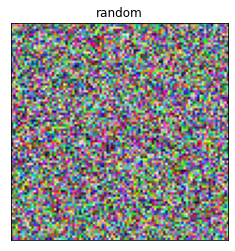

In [5]:
image = create_image()
plot_image(image)

Training

In [13]:
def find_image_that_activates_filter(layer_name, f_index=None, iters=50):
  submodel = get_submodel(layer_name)
  num_filters = submodel.output.shape[-1]

  if f_index is None:
    f_index = random.randint(0, num_filters-1)
  assert num_filters > f_index, 'f_index is out of bounds'

  image = create_image()
  info_step = int(iters/10)

  for i in range(0, iters):
    with tf.GradientTape() as tape:
      tape.watch(image)
      output=submodel(tf.expand_dims(image, axis=0))[:,:,:,f_index]
      mean_output=tf.math.reduce_mean(output)
    grad=tape.gradient(mean_output, image)
    grad=tf.math.l2_normalize(grad)
    image += grad * 10

    if (i+1)%info_step == 0:
      print(f'Iter:{i+1} Mean_output:{mean_output.numpy():.3f}')

  plot_image(image, f'{layer_name}, {f_index}')


Results

In [9]:
print([layer.name for layer in model.layers if 'conv' in layer.name])

['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']


Iter:10 Mean_output:5.874
Iter:20 Mean_output:11.042
Iter:30 Mean_output:16.003
Iter:40 Mean_output:21.124
Iter:50 Mean_output:26.274
Iter:60 Mean_output:32.465
Iter:70 Mean_output:38.872
Iter:80 Mean_output:45.626
Iter:90 Mean_output:53.318
Iter:100 Mean_output:61.243


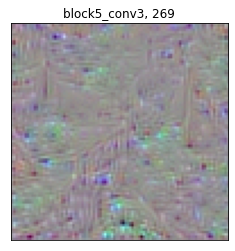

In [26]:
layer_name = 'block5_conv3'#@param['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3']
find_image_that_activates_filter(layer_name, iters=100)